In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
DATASET_PATH = './dataset/flights.csv'
DELAY_THRESHOLD = 15
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
def remove_unnecessary_columns(df):
    """Elimina columnas que no se usan"""
    keep_columns = [
        'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DISTANCE', 'YEAR', 'MONTH', 'DAY',
        'DEPARTURE_DELAY', 'CANCELLED', 'DIVERTED'
    ]
    available_cols = [col for col in keep_columns if col in df.columns]
    return df[available_cols].copy()

In [4]:
def clean_training_data(df):
    """Limpia datos de entrenamiento"""
    original_size = len(df)

    df = df[df['CANCELLED'] == 0].copy()
    df = df[df['DIVERTED'] == 0].copy()
    df = df.dropna(subset=['DEPARTURE_DELAY', 'SCHEDULED_DEPARTURE'])
    df = df[df['SCHEDULED_DEPARTURE'].between(0, 2359)]
    df = df[df['DISTANCE'] > 0]
    df = df[df['DEPARTURE_DELAY'].between(-60, 1440)]
    df = df.drop(['CANCELLED', 'DIVERTED'], axis=1)

    print(f"  → Removidos {original_size - len(df):,} registros inválidos")
    return df

In [5]:
def create_target(df, threshold):
    """Crea variable objetivo binaria"""
    df['IS_DELAYED'] = (df['DEPARTURE_DELAY'] > threshold).astype(int)
    return df

In [6]:
def categorize_period(hour):
    """Categoriza período del día"""
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

def get_season(month):
    """Obtiene la estación del año"""
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

def categorize_distance(distance):
    """Categoriza vuelos por distancia"""
    if distance < 500:
        return 'short'
    elif distance < 1500:
        return 'medium'
    else:
        return 'long'

In [7]:
def add_derived_features(df):
    """Crea features derivadas"""
    df = df.copy()

    # DAY_OF_WEEK
    if all(col in df.columns for col in ['YEAR', 'MONTH', 'DAY']):
        df['DAY_OF_WEEK'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']]).dt.dayofweek

    # HOUR y features relacionadas
    if 'SCHEDULED_DEPARTURE' in df.columns:
        df['HOUR'] = df['SCHEDULED_DEPARTURE'] // 100
        df['PERIOD_OF_DAY'] = df['HOUR'].apply(categorize_period)
        df['IS_NIGHT_FLIGHT'] = df['HOUR'].apply(lambda h: 1 if (h >= 22 or h < 6) else 0)
        df['IS_RUSH_HOUR'] = df['HOUR'].apply(lambda h: 1 if h in [6, 7, 8, 9, 17, 18, 19, 20] else 0)

    # FIN DE SEMANA
    if 'DAY_OF_WEEK' in df.columns:
        df['IS_WEEKEND'] = (df['DAY_OF_WEEK'] >= 5).astype(int)

    # SEASON
    if 'MONTH' in df.columns:
        df['SEASON'] = df['MONTH'].apply(get_season)

    # DISTANCE_CATEGORY
    if 'DISTANCE' in df.columns:
        df['DISTANCE_CATEGORY'] = df['DISTANCE'].apply(categorize_distance)

    return df

In [8]:
def encode_categorical_features(df):
    """Codifica variables categóricas con One-Hot Encoding"""
    df = df.copy()

    categorical_cols = [
        'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'PERIOD_OF_DAY', 'SEASON', 'DISTANCE_CATEGORY'
    ]

    categorical_cols = [col for col in categorical_cols if col in df.columns]

    df_encoded = pd.get_dummies(
        df,
        columns=categorical_cols,
        prefix=categorical_cols,
        drop_first=False
    )

    return df_encoded

In [9]:
print("\n" + "=" * 80)
print("PASO 1: CARGA DEL DATASET")
print("=" * 80)

print(f"📂 Cargando dataset desde {DATASET_PATH}...")
df = pd.read_csv(DATASET_PATH)
df = df[:1000000]
print(f"✓ Dataset cargado: {len(df):,} filas, {len(df.columns)} columnas")

print(f"\nPrimeras 5 filas:")
print(df.head())


PASO 1: CARGA DEL DATASET
📂 Cargando dataset desde ./dataset/flights.csv...
✓ Dataset cargado: 1,000,000 filas, 31 columnas

Primeras 5 filas:
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC        

✓ Gráfico guardado: eda_delays.png

✈️ Top 10 Aerolíneas:
AIRLINE
WN    210935
DL    140424
EV    105989
OO    102258
AA     93013
UA     83515
US     70657
MQ     62828
B6     45965
AS     28220
Name: count, dtype: int64


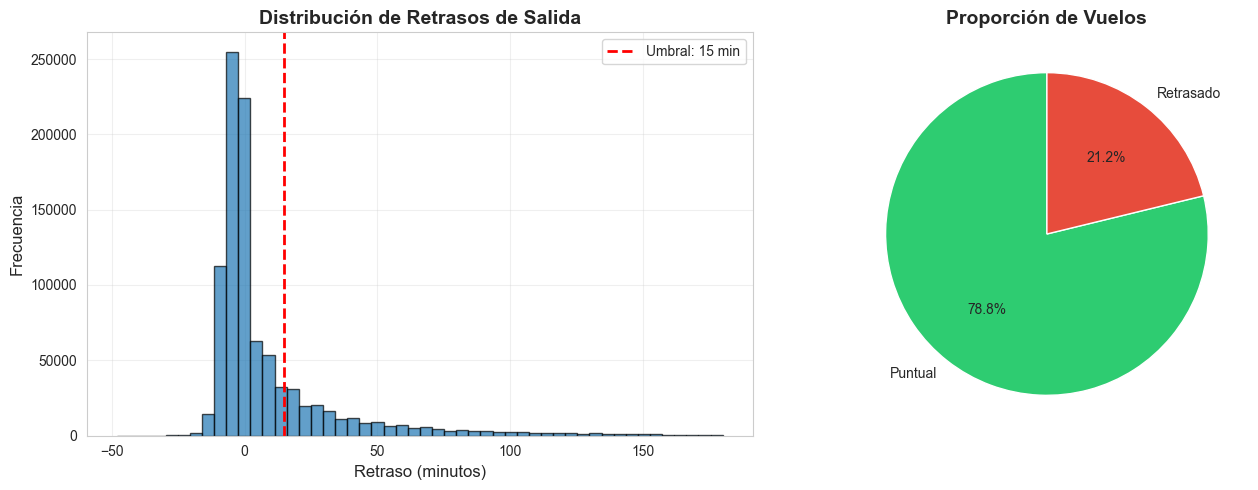

In [10]:
delays = df['DEPARTURE_DELAY'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(delays[delays.between(-60, 180)], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=DELAY_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'Umbral: {DELAY_THRESHOLD} min')
axes[0].set_xlabel('Retraso (minutos)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Retrasos de Salida', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

delay_counts = (delays > DELAY_THRESHOLD).value_counts()
axes[1].pie(delay_counts, labels=['Puntual', 'Retrasado'], autopct='%1.1f%%',
            startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Proporción de Vuelos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_delays.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: eda_delays.png")

print(f"\n✈️ Top 10 Aerolíneas:")
print(df['AIRLINE'].value_counts().head(10))

In [11]:
print("\n" + "=" * 80)
print("PASO 3: PREPARACIÓN DE DATOS")
print("=" * 80)

print("🔧 Removiendo columnas innecesarias...")
df_clean = remove_unnecessary_columns(df)
print(f"✓ Columnas reducidas de {len(df.columns)} a {len(df_clean.columns)}")

print("\n🔧 Limpiando datos...")
df_clean = clean_training_data(df_clean)
print(f"✓ Datos limpios: {len(df_clean):,} vuelos")

print("\n🔧 Creando variable objetivo...")
df_clean = create_target(df_clean, DELAY_THRESHOLD)
delayed_count = df_clean['IS_DELAYED'].sum()
print(f"✓ Target creado - Retrasos: {delayed_count:,} ({df_clean['IS_DELAYED'].mean()*100:.1f}%)")

print("\n🔧 Generando features derivadas...")
df_clean = add_derived_features(df_clean)
print(f"✓ Features derivadas creadas")

print("\n🔧 Aplicando One-Hot Encoding...")
df_encoded = encode_categorical_features(df_clean)
print(f"✓ Variables categóricas codificadas")


PASO 3: PREPARACIÓN DE DATOS
🔧 Removiendo columnas innecesarias...
✓ Columnas reducidas de 31 a 11

🔧 Limpiando datos...
  → Removidos 42,615 registros inválidos
✓ Datos limpios: 957,385 vuelos

🔧 Creando variable objetivo...
✓ Target creado - Retrasos: 202,151 (21.1%)

🔧 Generando features derivadas...
✓ Features derivadas creadas

🔧 Aplicando One-Hot Encoding...
✓ Variables categóricas codificadas


In [12]:
# Separar features y target
X = df_encoded.drop(['IS_DELAYED', 'DEPARTURE_DELAY'], axis=1, errors='ignore')
y = df_encoded['IS_DELAYED']

print(f"\n✓ Preparación completada")
print(f"  → Features (X): {X.shape}")
print(f"  → Target (y): {y.shape}")

# Guardar nombres de columnas para predicción
feature_columns = list(X.columns)
print(f"  → Total features: {len(feature_columns)}")


✓ Preparación completada
  → Features (X): (957385, 663)
  → Target (y): (957385,)
  → Total features: 663


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

In [14]:
# Decision Tree
print("\n🌳 [1/2] Entrenando Decision Tree...")
print("-" * 80)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

dt_model.fit(X_train, y_train)
print("✓ Entrenamiento completado")


🌳 [1/2] Entrenando Decision Tree...
--------------------------------------------------------------------------------
✓ Entrenamiento completado


In [15]:
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

In [16]:
print("\n📊 Resultados Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=['Puntual', 'Retrasado']))
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"ROC-AUC: {dt_auc:.4f}")


📊 Resultados Decision Tree:
              precision    recall  f1-score   support

     Puntual       0.88      0.65      0.75    151047
   Retrasado       0.34      0.67      0.45     40430

    accuracy                           0.65    191477
   macro avg       0.61      0.66      0.60    191477
weighted avg       0.76      0.65      0.68    191477

Accuracy: 0.6537
ROC-AUC: 0.7119


In [17]:
# Random Forest
print("\n🌲 [2/2] Entrenando Random Forest...")
print("-" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("✓ Entrenamiento completado")


🌲 [2/2] Entrenando Random Forest...
--------------------------------------------------------------------------------
✓ Entrenamiento completado


In [18]:
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [19]:
print("\n📊 Resultados Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Puntual', 'Retrasado']))
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"ROC-AUC: {rf_auc:.4f}")


📊 Resultados Random Forest:
              precision    recall  f1-score   support

     Puntual       0.87      0.51      0.64    151047
   Retrasado       0.28      0.73      0.41     40430

    accuracy                           0.56    191477
   macro avg       0.58      0.62      0.53    191477
weighted avg       0.75      0.56      0.59    191477

Accuracy: 0.5551
ROC-AUC: 0.6771


In [20]:
print("\n" + "=" * 80)
print("PASO 6: SELECCIÓN DEL MEJOR MODELO")
print("=" * 80)

comparison = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Random Forest'],
    'Accuracy': [dt_accuracy, rf_accuracy],
    'ROC-AUC': [dt_auc, rf_auc]
})
print("\n", comparison.to_string(index=False))

if dt_auc > rf_auc:
    best_model = dt_model
    best_model_name = 'DecisionTree'
    winner = 'Decision Tree'
else:
    best_model = rf_model
    best_model_name = 'RandomForest'
    winner = 'Random Forest'

print(f"\n🏆 MODELO GANADOR: {winner}")
print(f"   → ROC-AUC: {max(dt_auc, rf_auc):.4f}")


PASO 6: SELECCIÓN DEL MEJOR MODELO

        Modelo  Accuracy  ROC-AUC
Decision Tree  0.653729 0.711902
Random Forest  0.555142 0.677096

🏆 MODELO GANADOR: Decision Tree
   → ROC-AUC: 0.7119


In [21]:
print("\n" + "=" * 80)
print("PASO 8: GUARDANDO ARTEFACTOS PARA PREDICCIÓN")
print("=" * 80)

# Guardar modelos
joblib.dump(dt_model, './models/decision_tree_model.pkl')
joblib.dump(rf_model, './models/random_forest_model.pkl')
joblib.dump(best_model, './models/best_model.pkl')
print(f"✓ Modelos guardados")

# Guardar metadata necesaria para predicción
prediction_metadata = {
    'best_model_name': best_model_name,
    'feature_columns': feature_columns,
    'delay_threshold': DELAY_THRESHOLD,
    'metrics': {
        'decision_tree': {'accuracy': dt_accuracy, 'roc_auc': dt_auc},
        'random_forest': {'accuracy': rf_accuracy, 'roc_auc': rf_auc}
    }
}

joblib.dump(prediction_metadata, './metadata/prediction_metadata.pkl')
print("✓ Metadata guardada")


PASO 8: GUARDANDO ARTEFACTOS PARA PREDICCIÓN
✓ Modelos guardados
✓ Metadata guardada
